In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import dask
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, FuncFormatter
from dask.distributed import Client, LocalCluster
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp
from datetime import date

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

# DAILY snow
snow_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/snow_m/*.nc" ]

rain_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/rain_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/rain_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/rain_m/*.nc" ]

temp_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/tsa_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/tsa_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/tsa_m/*.nc" ]

better_h2osno_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/swe_d/*.nc" ]

qrunoff_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/qrunoff_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/qrunoff_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/qrunoff_m/*.nc" ]

snow_P, snow_H, snow_M = unpacker(snow_paths, "SNOW")
rain_P, rain_H, rain_M = unpacker(rain_paths, "RAIN")
temp_P, temp_H, temp_M = unpacker(temp_paths, "TSA")
better_h2osno_P, better_h2osno_H, better_h2osno_M = unpacker(better_h2osno_paths, "H2OSNO")
qrunoff_P, qrunoff_H, qrunoff_M = unpacker(qrunoff_paths, "QRUNOFF")

In [3]:
### Data editing
## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Helpers for our cache functions
def compute_annual_generic(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_annual_runoff(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_geo_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(2034, 2064))

def compute_geo_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(1990, 2020))

def compute_layer_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(2034, 2064))

def compute_layer_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(1990, 2020))

## Precipitation
total_precip_P = (rain_P + snow_P) * seconds_per_year
total_precip_H = (rain_H + snow_H) * seconds_per_year
total_precip_M = (rain_M + snow_M) * seconds_per_year

total_precip_P.name = "PRECIP_P"
total_precip_H.name = "PRECIP_H"
total_precip_M.name = "PRECIP_M"

annual_precip_P = cache_xarray(compute_annual_generic, total_precip_P, name_hint="annual_precip_P")
annual_precip_H = cache_xarray(compute_annual_generic, total_precip_H, name_hint="annual_precip_H")
annual_precip_M = cache_xarray(compute_annual_generic, total_precip_M, name_hint="annual_precip_M")

## Snow
total_snow_P = (snow_P) * seconds_per_year
total_snow_H = (snow_H) * seconds_per_year
total_snow_M = (snow_M) * seconds_per_year

annual_snow_P = cache_xarray(compute_annual_generic, total_snow_P, name_hint="annual_snow_P")
annual_snow_H = cache_xarray(compute_annual_generic, total_snow_H, name_hint="annual_snow_H")
annual_snow_M = cache_xarray(compute_annual_generic, total_snow_M, name_hint="annual_snow_M")

## Rain
total_rain_P = (rain_P) * seconds_per_year
total_rain_H = (rain_H) * seconds_per_year
total_rain_M = (rain_M) * seconds_per_year

annual_rain_P = cache_xarray(compute_annual_generic, total_rain_P, name_hint="annual_rain_P")
annual_rain_H = cache_xarray(compute_annual_generic, total_rain_H, name_hint="annual_rain_H")
annual_rain_M = cache_xarray(compute_annual_generic, total_rain_M, name_hint="annual_rain_M")

## Runoff
total_qrunoff_P = qrunoff_P * seconds_per_year
total_qrunoff_H = qrunoff_H * seconds_per_year
total_qrunoff_M = qrunoff_M * seconds_per_year

annual_qrunoff_P = cache_xarray(compute_annual_runoff, total_qrunoff_P, name_hint="annual_qrunoff_P")
annual_qrunoff_H = cache_xarray(compute_annual_runoff, total_qrunoff_H, name_hint="annual_qrunoff_H")
annual_qrunoff_M = cache_xarray(compute_annual_runoff, total_qrunoff_M, name_hint="annual_qrunoff_M")

## Temp
total_temp_P = temp_P
total_temp_H = temp_H
total_temp_M = temp_M

annual_temp_P = cache_xarray(compute_annual_generic, total_temp_P, name_hint="annual_temp_P")
annual_temp_H = cache_xarray(compute_annual_generic, total_temp_H, name_hint="annual_temp_H")
annual_temp_M = cache_xarray(compute_annual_generic, total_temp_M, name_hint="annual_temp_M")

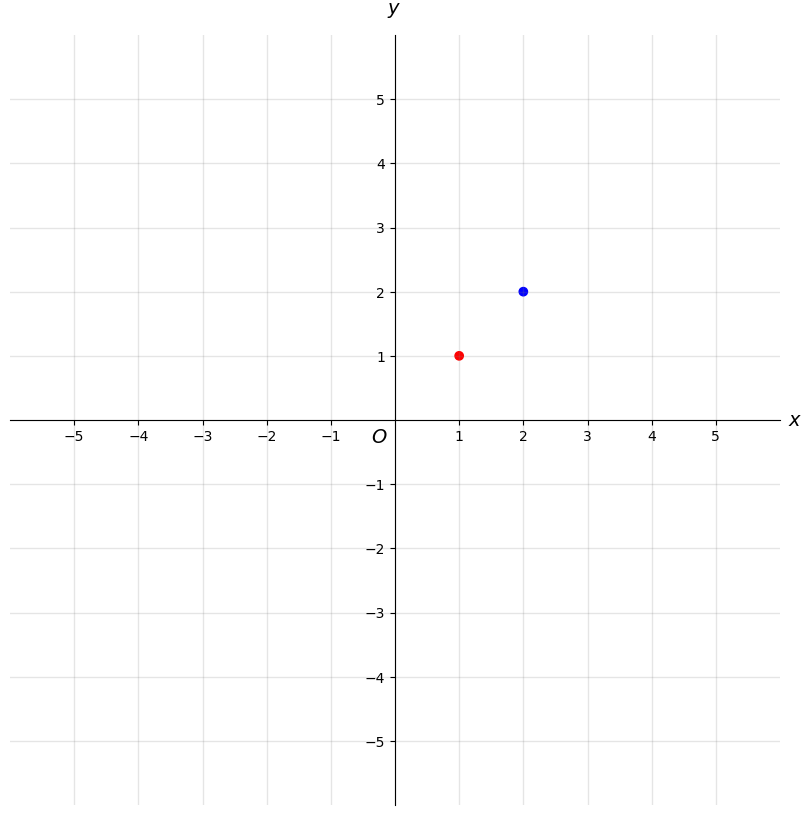

In [4]:
### Data visualization: Cartesian grid

# the code below makes a cartesian grid.
# you'll need to change the constants so that you get something you want out of it.
# it's just left here as an example of a working version
xmin, xmax, ymin, ymax = -5, 5, -5, 5
ticks = 1

fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')

# this creates our x-y grid lines...
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
# and this hides the edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
 
plt.text(0.49, 0.49, "$O$", ha='right', va='top', 
         transform=ax.transAxes,
         horizontalalignment='center', fontsize=14)

x_ticks = np.arange(xmin, xmax+1, ticks)
y_ticks = np.arange(ymin, ymax+1, ticks)

ax.set_xticks(x_ticks[x_ticks != 0])
ax.set_yticks(y_ticks[y_ticks != 0])
ax.set_xticks(np.arange(xmin, xmax+1), minor=True)
ax.set_yticks(np.arange(ymin, ymax+1), minor=True)
ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

# the easiest way to make plots
ax.scatter([1, 2], [1, 2], c=["r", "b"])

precip ratio_P values: [(0.6727590560913086, 1989), (0.6570547223091125, 1990), (0.6928119659423828, 1991), (0.6306246519088745, 1992), (0.683779776096344, 1993), (0.6840282678604126, 1994), (0.7388060092926025, 1995), (0.6203224062919617, 1996), (0.6910561919212341, 1997), (0.6636061072349548, 1998), (0.6913560628890991, 1999), (0.6741876602172852, 2000), (0.7561012506484985, 2001), (0.6980148553848267, 2002), (0.6900258660316467, 2003), (0.6593422889709473, 2004), (0.6915351748466492, 2005), (0.7127120494842529, 2006), (0.6686927676200867, 2007), (0.6918374300003052, 2008), (0.7231469750404358, 2009), (0.6522315144538879, 2010), (0.6769344210624695, 2011), (0.7228249311447144, 2012), (0.7064071893692017, 2013), (0.7285142540931702, 2014), (0.663749098777771, 2015), (0.7455533146858215, 2016), (0.64338618516922, 2017), (0.7203027606010437, 2018), (0.6775317192077637, 2019), (0.6965113878250122, 2020), (0.7937515377998352, 2021)]

temp_P values: [(np.float32(6.9078674), 1989), (np.floa

<Figure size 3840x2880 with 0 Axes>

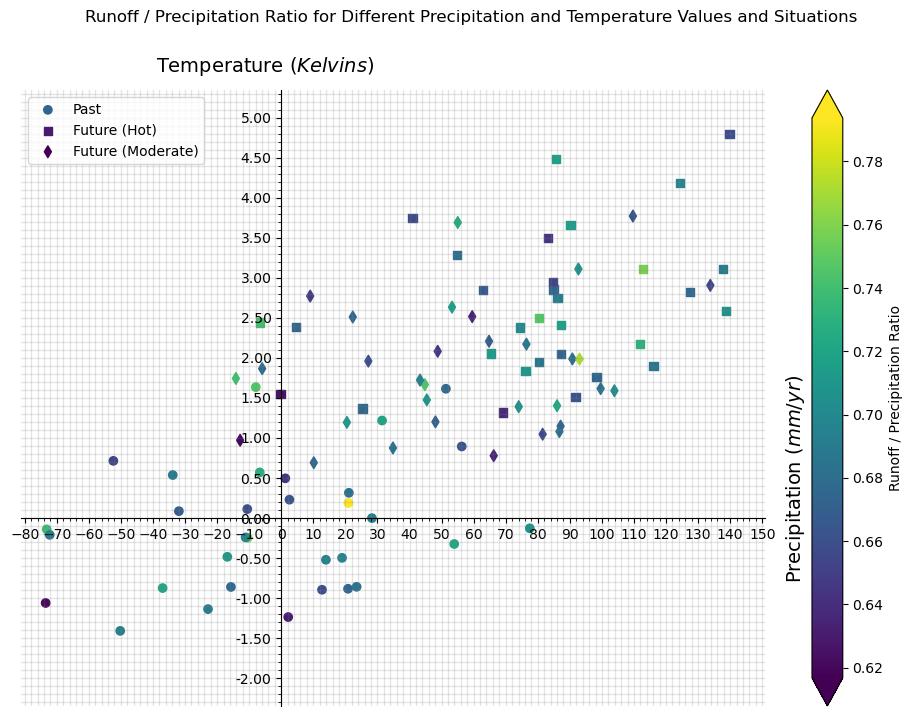

In [5]:
### Data visualization: Cartesian grid
# the first step is to get an average over all space and time:
total_avg_qrunoff_P = annual_qrunoff_P.mean(dim=('lat', 'lon', 'year'))
total_avg_qrunoff_H = annual_qrunoff_H.mean(dim=('lat', 'lon', 'year'))
total_avg_qrunoff_M = annual_qrunoff_M.mean(dim=('lat', 'lon', 'year'))

total_avg_snow_P = annual_snow_P.mean(dim=('lat', 'lon', 'year'))
total_avg_snow_H = annual_snow_H.mean(dim=('lat', 'lon', 'year'))
total_avg_snow_M = annual_snow_M.mean(dim=('lat', 'lon', 'year'))

total_avg_rain_P = annual_rain_P.mean(dim=('lat', 'lon', 'year'))
total_avg_rain_H = annual_rain_H.mean(dim=('lat', 'lon', 'year'))
total_avg_rain_M = annual_rain_M.mean(dim=('lat', 'lon', 'year'))

total_avg_precip_P = annual_precip_P.mean(dim=('lat', 'lon', 'year'))
total_avg_precip_H = annual_precip_H.mean(dim=('lat', 'lon', 'year'))
total_avg_precip_M = annual_precip_M.mean(dim=('lat', 'lon', 'year'))

years_P = [x.item() for x in annual_qrunoff_P.year.values]
years_H = [x.item() for x in annual_qrunoff_H.year.values]
years_M = [x.item() for x in annual_qrunoff_M.year.values]
# now we need to loop over them by year to get the values by year.

# this value is the center of our coordinate grid.
# we define all points relative to these values.
x_origin, y_origin = total_precip_P.mean().values, total_temp_P.mean().values
#x_origin, y_origin = 750, 280

## HISTORICAL
# color
precip_ratio_values_P = [(annual_qrunoff_P.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_P.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_P]
# y axis 
temp_values_P = [(annual_temp_P.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_P]
# x axis
precip_values_P = [(annual_precip_P.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_P]

## FUTURE HOT
# color
precip_ratio_values_H = [(annual_qrunoff_H.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_H.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_H]
# y axis 
temp_values_H = [(annual_temp_H.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_H]
# x axis
precip_values_H = [(annual_precip_H.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_H]

## FUTURE MODERATE
# color
precip_ratio_values_M = [(annual_qrunoff_M.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_M.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_M]
# y axis 
temp_values_M = [(annual_temp_M.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_M]
# x axis
precip_values_M = [(annual_precip_M.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_M]

all_heats = np.concatenate([
    precip_ratio_values_P,
    precip_ratio_values_H,
    precip_ratio_values_M
])

vmin, vmax = all_heats.min(), all_heats.max()

print(f"precip ratio_P values: {list(zip(precip_ratio_values_P,years_P))}")
print()
print(f"temp_P values: {list(zip(temp_values_P,years_P))}")
print()
print(f"precip_P values: {list(zip(precip_values_P,years_P))}")
print()
print(f"combined_P coords: {list(zip(precip_values_P, temp_values_P))}")
print()

print(f"precip ratio_H values: {list(zip(precip_ratio_values_H,years_H))}")
print()
print(f"temp_H values: {list(zip(temp_values_H,years_H))}")
print()
print(f"precip_H values: {list(zip(precip_values_H,years_H))}")
print()
print(f"combined_H coords: {list(zip(precip_values_H, temp_values_H))}")
print()

print(f"precip ratio_M values: {list(zip(precip_ratio_values_M,years_M))}")
print()
print(f"temp_M values: {list(zip(temp_values_M,years_M))}")
print()
print(f"precip_M values: {list(zip(precip_values_M,years_M))}")
print()
print(f"combined_M coords: {list(zip(precip_values_M, temp_values_M))}")
print()

#xmin, xmax = total_precip_P.max(), total_precip_P.min()

## cartesian grid
#xmin, xmax = (total_precip_P.max() - x_origin).values, (x_origin - total_precip_P.max()).values
#ymin, ymax = (total_temp_P.max() - y_origin).values, (y_origin - total_temp_P.max()).values

# We're defining it manually because using calculated values is extremely error-prone
xmin, xmax = -80, 150
#xmin, xmax = -150, 150
ymin, ymax = -2, 5
#ymin, ymax = -14, 14
ticks_x = 10
#ticks_x = 20
ticks_y = 0.5
#ticks_y = 4

plt.figure(dpi=600)
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-0.05*(ymax-ymin), ymax+0.05*(ymax-ymin)), aspect='auto')

# axes styling
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Precipitation $(mm/yr)$', size=14, labelpad=-120, x=1.04, rotation=-270)
ax.set_ylabel('Temperature $(Kelvins)$', size=14, labelpad=-21, y=1.02, rotation=0)
#ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
#ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
#plt.text(0.49, 0.49, "$O$", transform=ax.transAxes, ha='center', va='top', fontsize=14)

# grid ticks
ax.xaxis.set_major_locator(MultipleLocator(ticks_x))
ax.xaxis.set_minor_locator(MultipleLocator(ticks_x / 5))
ax.yaxis.set_major_locator(MultipleLocator(ticks_y))
ax.yaxis.set_minor_locator(MultipleLocator(ticks_y / 5))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

plt.suptitle("Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations")

# the easiest way to make plots
sc1 = ax.scatter(precip_values_P, temp_values_P, c=precip_ratio_values_P, label="Past",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="o")
sc2 = ax.scatter(precip_values_H, temp_values_H, c=precip_ratio_values_H, label="Future (Hot)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="s")
sc3 = ax.scatter(precip_values_M, temp_values_M, c=precip_ratio_values_M, label="Future (Moderate)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="d")
plt.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
plt.legend()



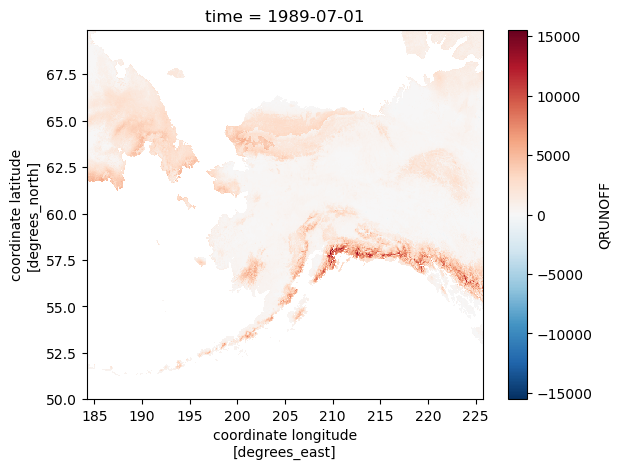

In [6]:
total_qrunoff_P.sel(time=slice("1989-07-01")).plot()

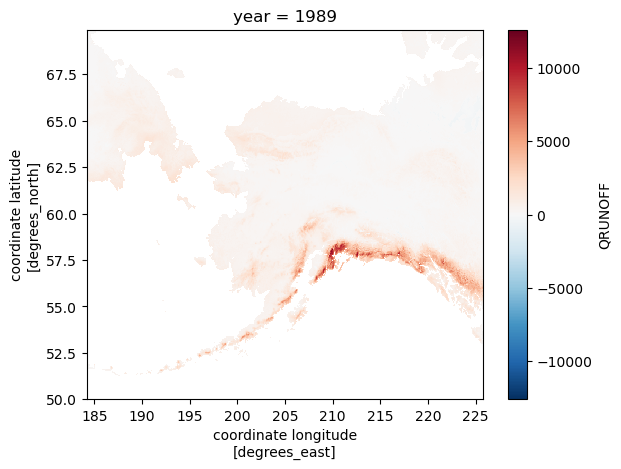

In [7]:
annual_qrunoff_P.sel(year=1989).plot()

In [8]:
annual_precip_P.mean()

<xarray.DataArray 'PRECIP_P' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [9]:
annual_temp_P.mean()

<xarray.DataArray 'TSA' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [10]:
x_origin, y_origin = total_precip_P.mean(), total_temp_P.mean()
xmin, xmax = total_precip_P.max() - x_origin, x_origin - total_precip_P.max()
ymin, ymax = total_temp_P.max() - y_origin, y_origin - total_temp_P.max()
print(f"Y: {ymin.values}, {ymax.values}")
print(f"X: {xmin.values}, {xmax.values}")

print(f"Y raw: {total_temp_P.mean().values}, {total_temp_P.max().values}")
print(f"X raw: {total_precip_P.mean().values}, {total_precip_P.max().values}")

print(f"Y std: {total_temp_P.std().values}")
print(f"X std: {total_precip_P.std().values}")

Y: 28.1676025390625, -28.1676025390625
X: 39160.15625, -39160.15625
Y raw: 268.059814453125, 296.2274169921875
X raw: 704.158203125, 39864.3125
Y std: 11.906401634216309
X std: 969.1800537109375


In [11]:
total_qrunoff_P

<xarray.DataArray 'QRUNOFF' (time: 388, lat: 662, lon: 782)> Size: 803MB
dask.array<mul, shape=(388, 662, 782), dtype=float32, chunksize=(12, 662, 782), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1989-07-01 1989-08-01 ... 2021-10-01
  * lon      (lon) float32 3kB 184.2 184.3 184.3 184.4 ... 225.7 225.7 225.8
  * lat      (lat) float32 3kB 50.01 50.04 50.07 50.11 ... 69.83 69.86 69.89

In [12]:
def winterizer(ds):
    """Takes a dataset in, returns a version with means for the winter months."""
    djfm = ds.sel(time=ds.time.dt.month.isin([12, 1, 2, 3]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    
    djfm.coords['season_year'] = get_season_year(djfm.time).astype('int32')
    def reduction_method(ds):
        return ds.groupby('season_year').mean(dim=('lat','lon', 'time'))

    return djfm.groupby('season_year').mean(dim=('lat','lon', 'time'))

    # TODO: fix cache_xarray() here
    #return cache_xarray(reduction_method, djfm, name_hint="djfm")

final = winterizer(total_snow_P)
final
    

<xarray.DataArray 'SNOW' (season_year: 32)> Size: 128B
dask.array<stack, shape=(32,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * season_year  (season_year) int32 128B 1990 1991 1992 1993 ... 2019 2020 2021

In [13]:
def summerizer(ds):
    """Takes a dataset in, returns a version with means for the summer months."""
    mjja = ds.sel(time=ds.time.dt.month.isin([5, 6, 7, 8]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    mjja.coords['season_year'] = get_season_year(mjja.time).astype('int32')
    def reduction_method(ds):
        return ds.groupby('season_year').mean(dim=('lat','lon', 'time'))

    return mjja.groupby('season_year').mean(dim=('lat','lon', 'time'))

    # TODO: fix cache_xarray() here
    #return cache_xarray(reduction_method, djfm, name_hint="djfm")

final = summerizer(total_snow_P)
final

<xarray.DataArray 'SNOW' (season_year: 33)> Size: 132B
dask.array<stack, shape=(33,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * season_year  (season_year) int32 132B 1989 1990 1991 1992 ... 2019 2020 2021

precip ratio_P values: [(0.18961739540100098, 1990), (0.1751614660024643, 1991), (0.24707363545894623, 1992), (0.21226033568382263, 1993), (0.25267285108566284, 1994), (0.1955537348985672, 1995), (0.22139282524585724, 1996), (0.24852313101291656, 1997), (0.24618378281593323, 1998), (0.23889994621276855, 1999), (0.24170541763305664, 2000), (0.29259371757507324, 2001), (0.2582419514656067, 2002), (0.37365612387657166, 2003), (0.24050405621528625, 2004), (0.23219162225723267, 2005), (0.2942018508911133, 2006), (0.22862181067466736, 2007), (0.23874548077583313, 2008), (0.24199825525283813, 2009), (0.2551027238368988, 2010), (0.22883230447769165, 2011), (0.24310478568077087, 2012), (0.2317453920841217, 2013), (0.2903056740760803, 2014), (0.3295447528362274, 2015), (0.2888718843460083, 2016), (0.1999141126871109, 2017), (0.23256954550743103, 2018), (0.25207820534706116, 2019), (0.26258769631385803, 2020), (0.24704121053218842, 2021)]

temp_P values: [(np.float32(-3.3315887), 1990), (np.float

<Figure size 3840x2880 with 0 Axes>

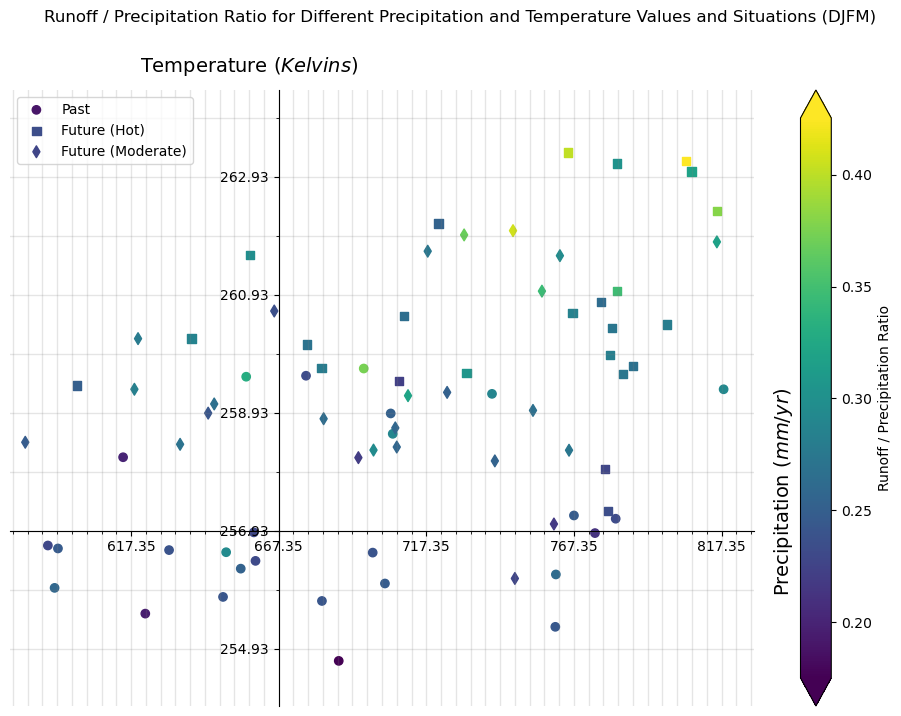

In [14]:
### Data visualization: Cartesian grid (but for wintertime)

## GLOBAL

# years value we'll use later
years_P = [x.item() for x in winterizer(total_qrunoff_P).season_year.values]
years_H = [x.item() for x in winterizer(total_qrunoff_H).season_year.values]
years_M = [x.item() for x in winterizer(total_qrunoff_M).season_year.values]

# important helper function to get a winter season
def winterizer(ds):
    """Takes a dataset in, returns a version with means for the winter months."""
    djfm = ds.sel(time=ds.time.dt.month.isin([12, 1, 2, 3]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    
    djfm.coords['season_year'] = get_season_year(djfm.time).astype('int32')
    return djfm.groupby('season_year').mean(dim=('lat','lon', 'time'))

# this value is the center of our coordinate grid.
# we define all points relative to these values.
x_origin, y_origin = winterizer(total_precip_P).mean().values, winterizer(total_temp_P).mean().values

## HISTORICAL
# color
precip_ratio_values_P = [(winterizer(total_qrunoff_P).sel(season_year=x).values / winterizer(total_precip_P).sel(season_year=x).values).item()
           for x in years_P]
# y axis 
temp_values_P = [(winterizer(total_temp_P).sel(season_year=x).values).item() - y_origin
           for x in years_P]
# x axis
precip_values_P = [(winterizer(total_precip_P).sel(season_year=x).values).item() - x_origin
           for x in years_P]

## FUTURE HOT
# color
precip_ratio_values_H = [(winterizer(total_qrunoff_H).sel(season_year=x).values / winterizer(total_precip_H).sel(season_year=x).values).item()
           for x in years_H]
# y axis 
temp_values_H = [(winterizer(total_temp_H).sel(season_year=x).values).item() - y_origin
           for x in years_H]
# x axis
precip_values_H = [(winterizer(total_precip_H).sel(season_year=x).values).item() - x_origin
           for x in years_H]

## FUTURE MODERATE
# color
precip_ratio_values_M = [(winterizer(total_qrunoff_M).sel(season_year=x).values / winterizer(total_precip_M).sel(season_year=x).values).item()
           for x in years_M]
# y axis 
temp_values_M = [(winterizer(total_temp_M).sel(season_year=x).values).item() - y_origin
           for x in years_M]
# x axis
precip_values_M = [(winterizer(total_precip_M).sel(season_year=x).values).item() - x_origin
           for x in years_M]

all_heats = np.concatenate([
    precip_ratio_values_P,
    precip_ratio_values_H,
    precip_ratio_values_M
])

vmin, vmax = all_heats.min(), all_heats.max()

print(f"precip ratio_P values: {list(zip(precip_ratio_values_P,years_P))}")
print()
print(f"temp_P values: {list(zip(temp_values_P,years_P))}")
print()
print(f"precip_P values: {list(zip(precip_values_P,years_P))}")
print()
print(f"combined_P coords: {list(zip(precip_values_P, temp_values_P))}")
print()

print(f"precip ratio_H values: {list(zip(precip_ratio_values_H,years_H))}")
print()
print(f"temp_H values: {list(zip(temp_values_H,years_H))}")
print()
print(f"precip_H values: {list(zip(precip_values_H,years_H))}")
print()
print(f"combined_H coords: {list(zip(precip_values_H, temp_values_H))}")
print()

print(f"precip ratio_M values: {list(zip(precip_ratio_values_M,years_M))}")
print()
print(f"temp_M values: {list(zip(temp_values_M,years_M))}")
print()
print(f"precip_M values: {list(zip(precip_values_M,years_M))}")
print()
print(f"combined_M coords: {list(zip(precip_values_M, temp_values_M))}")
print()


# We're defining it manually because using calculated values is extremely error-prone
xmin, xmax = -90, 160
#xmin, xmax = -150, 150
ymin, ymax = -2.5, 7
#ymin, ymax = -14, 14
ticks_x = 10
#ticks_x = 20
ticks_y = 2
#ticks_y = 4

plt.figure(dpi=600)
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-0.05*(ymax-ymin), ymax+0.05*(ymax-ymin)), aspect='auto')

# axes styling
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Precipitation $(mm/yr)$', size=14, labelpad=-120, x=1.04, rotation=-270)
ax.set_ylabel('Temperature $(Kelvins)$', size=14, labelpad=-21, y=1.02, rotation=0)
#ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
#ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
#plt.text(0.49, 0.49, "$O$", transform=ax.transAxes, ha='center', va='top', fontsize=14)

# grid ticks
ax.xaxis.set_major_locator(MultipleLocator(ticks_x * 5))
ax.xaxis.set_minor_locator(MultipleLocator(ticks_x / 2))
ax.yaxis.set_major_locator(MultipleLocator(ticks_y))
ax.yaxis.set_minor_locator(MultipleLocator(ticks_y / 2))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{(y + y_origin):.2f}'))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{(x + x_origin):.2f}'))
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

plt.suptitle("Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations (DJFM)")

# the easiest way to make plots
sc1 = ax.scatter(precip_values_P, temp_values_P, c=precip_ratio_values_P, label="Past",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="o")
sc2 = ax.scatter(precip_values_H, temp_values_H, c=precip_ratio_values_H, label="Future (Hot)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="s")
sc3 = ax.scatter(precip_values_M, temp_values_M, c=precip_ratio_values_M, label="Future (Moderate)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="d")
plt.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
plt.legend()


precip ratio_P values: [(1.086251974105835, 1989), (1.410305380821228, 1990), (1.4701282978057861, 1991), (1.3688629865646362, 1992), (1.6599375009536743, 1993), (1.320594310760498, 1994), (1.3424670696258545, 1995), (1.2157578468322754, 1996), (1.3588323593139648, 1997), (1.1219888925552368, 1998), (1.2387912273406982, 1999), (1.3946290016174316, 2000), (1.53764009475708, 2001), (1.363209843635559, 2002), (1.2628679275512695, 2003), (1.4579973220825195, 2004), (1.513978123664856, 2005), (1.2695391178131104, 2006), (1.3744003772735596, 2007), (1.2330207824707031, 2008), (1.5903749465942383, 2009), (1.238033652305603, 2010), (1.2355844974517822, 2011), (1.3433947563171387, 2012), (1.425159215927124, 2013), (1.3208907842636108, 2014), (1.275376319885254, 2015), (1.2780158519744873, 2016), (1.211965799331665, 2017), (1.4211498498916626, 2018), (1.4552637338638306, 2019), (1.4080822467803955, 2020), (1.521729588508606, 2021)]

temp_P values: [(np.float32(6.6809387), 1989), (np.float32(0.64

<Figure size 3840x2880 with 0 Axes>

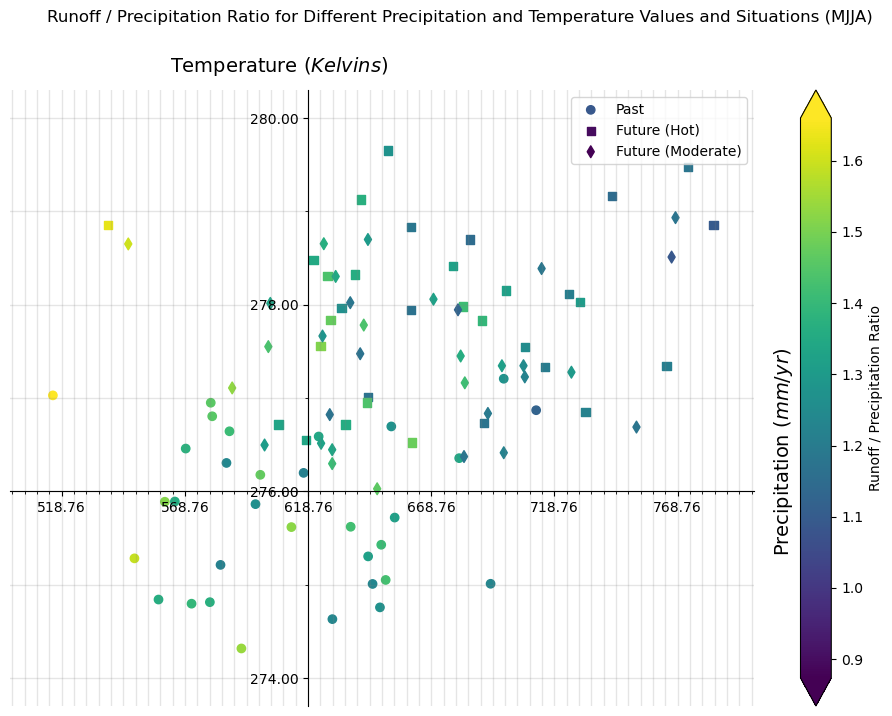

In [15]:
### Data visualization: Cartesian grid (but for summertime)

## GLOBAL

# years value we'll use later
years_P = [x.item() for x in summerizer(total_qrunoff_P).season_year.values]
years_H = [x.item() for x in summerizer(total_qrunoff_H).season_year.values]
years_M = [x.item() for x in summerizer(total_qrunoff_M).season_year.values]

# important helper function to get a summer season
def summerizer(ds):
    """Takes a dataset in, returns a version with means for the summer months."""
    mjja = ds.sel(time=ds.time.dt.month.isin([5, 6, 7, 8]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    mjja.coords['season_year'] = get_season_year(mjja.time).astype('int32')
    
    return mjja.groupby('season_year').mean(dim=('lat','lon', 'time'))

# this value is the center of our coordinate grid.
# we define all points relative to these values.
x_origin, y_origin = summerizer(total_precip_P).mean().values, summerizer(total_temp_P).mean().values

## HISTORICAL
# color
precip_ratio_values_P = [(summerizer(total_qrunoff_P).sel(season_year=x).values / summerizer(total_precip_P).sel(season_year=x).values).item()
           for x in years_P]
# y axis 
temp_values_P = [(summerizer(total_temp_P).sel(season_year=x).values).item() - y_origin
           for x in years_P]
# x axis
precip_values_P = [(summerizer(total_precip_P).sel(season_year=x).values).item() - x_origin
           for x in years_P]

## FUTURE HOT
# color
precip_ratio_values_H = [(summerizer(total_qrunoff_H).sel(season_year=x).values / summerizer(total_precip_H).sel(season_year=x).values).item()
           for x in years_H]
# y axis 
temp_values_H = [(summerizer(total_temp_H).sel(season_year=x).values).item() - y_origin
           for x in years_H]
# x axis
precip_values_H = [(summerizer(total_precip_H).sel(season_year=x).values).item() - x_origin
           for x in years_H]

## FUTURE MODERATE
# color
precip_ratio_values_M = [(summerizer(total_qrunoff_M).sel(season_year=x).values / summerizer(total_precip_M).sel(season_year=x).values).item()
           for x in years_M]
# y axis 
temp_values_M = [(summerizer(total_temp_M).sel(season_year=x).values).item() - y_origin
           for x in years_M]
# x axis
precip_values_M = [(summerizer(total_precip_M).sel(season_year=x).values).item() - x_origin
           for x in years_M]

all_heats = np.concatenate([
    precip_ratio_values_P,
    precip_ratio_values_H,
    precip_ratio_values_M
])

vmin, vmax = all_heats.min(), all_heats.max()

print(f"precip ratio_P values: {list(zip(precip_ratio_values_P,years_P))}")
print()
print(f"temp_P values: {list(zip(temp_values_P,years_P))}")
print()
print(f"precip_P values: {list(zip(precip_values_P,years_P))}")
print()
print(f"combined_P coords: {list(zip(precip_values_P, temp_values_P))}")
print()

print(f"precip ratio_H values: {list(zip(precip_ratio_values_H,years_H))}")
print()
print(f"temp_H values: {list(zip(temp_values_H,years_H))}")
print()
print(f"precip_H values: {list(zip(precip_values_H,years_H))}")
print()
print(f"combined_H coords: {list(zip(precip_values_H, temp_values_H))}")
print()

print(f"precip ratio_M values: {list(zip(precip_ratio_values_M,years_M))}")
print()
print(f"temp_M values: {list(zip(temp_values_M,years_M))}")
print()
print(f"precip_M values: {list(zip(precip_values_M,years_M))}")
print()
print(f"combined_M coords: {list(zip(precip_values_M, temp_values_M))}")
print()


# We're defining it manually because using calculated values is extremely error-prone
xmin, xmax = -120, 180
#xmin, xmax = -150, 150
ymin, ymax = -2, 4
#ymin, ymax = -14, 14
ticks_x = 10
#ticks_x = 20
ticks_y = 2
#ticks_y = 4

plt.figure(dpi=600)
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-0.05*(ymax-ymin), ymax+0.05*(ymax-ymin)), aspect='auto')

# axes styling
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Precipitation $(mm/yr)$', size=14, labelpad=-120, x=1.04, rotation=-270)
ax.set_ylabel('Temperature $(Kelvins)$', size=14, labelpad=-21, y=1.02, rotation=0)
#ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
#ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
#plt.text(0.49, 0.49, "$O$", transform=ax.transAxes, ha='center', va='top', fontsize=14)

# grid ticks
ax.xaxis.set_major_locator(MultipleLocator(ticks_x * 5))
ax.xaxis.set_minor_locator(MultipleLocator(ticks_x / 2))
ax.yaxis.set_major_locator(MultipleLocator(ticks_y))
ax.yaxis.set_minor_locator(MultipleLocator(ticks_y / 2))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{(y + y_origin):.2f}'))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{(x + x_origin):.2f}'))
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

plt.suptitle("Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations (MJJA)")

# the easiest way to make plots
sc1 = ax.scatter(precip_values_P, temp_values_P, c=precip_ratio_values_P, label="Past",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="o")
sc2 = ax.scatter(precip_values_H, temp_values_H, c=precip_ratio_values_H, label="Future (Hot)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="s")
sc3 = ax.scatter(precip_values_M, temp_values_M, c=precip_ratio_values_M, label="Future (Moderate)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="d")
plt.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
plt.legend()

In [16]:
### Data visualization: regional analysis of the same situation.


In [17]:
model_grid

<xarray.Dataset> Size: 6MB
Dimensions:      (x: 662, y: 782)
Coordinates:
    lat          (x, y) float32 2MB dask.array<chunksize=(662, 782), meta=np.ndarray>
    lon          (x, y) float32 2MB dask.array<chunksize=(662, 782), meta=np.ndarray>
    spatial_ref  int32 4B ...
Dimensions without coordinates: x, y
Data variables:
    OBJECTID     (x, y) float32 2MB dask.array<chunksize=(662, 782), meta=np.ndarray>

In [18]:
total_qrunoff_P

<xarray.DataArray 'QRUNOFF' (time: 388, lat: 662, lon: 782)> Size: 803MB
dask.array<mul, shape=(388, 662, 782), dtype=float32, chunksize=(12, 662, 782), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1989-07-01 1989-08-01 ... 2021-10-01
  * lon      (lon) float32 3kB 184.2 184.3 184.3 184.4 ... 225.7 225.7 225.8
  * lat      (lat) float32 3kB 50.01 50.04 50.07 50.11 ... 69.83 69.86 69.89

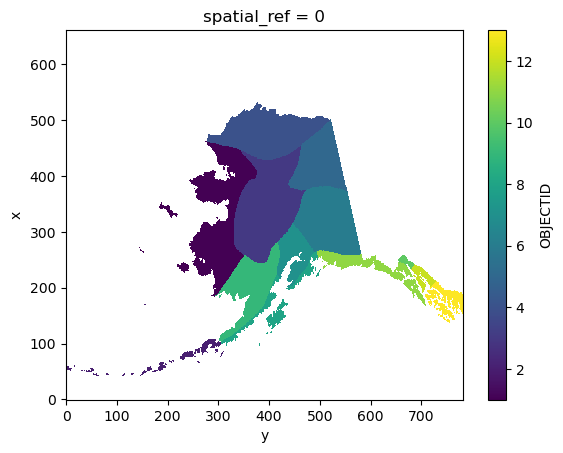

In [19]:
model_grid.OBJECTID.plot()

In [20]:
coords = model_grid.where(model_grid['OBJECTID'] == 1)

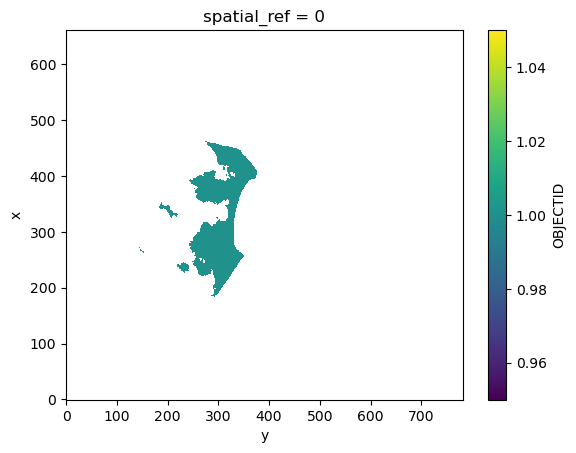

In [21]:
coords.OBJECTID.plot()

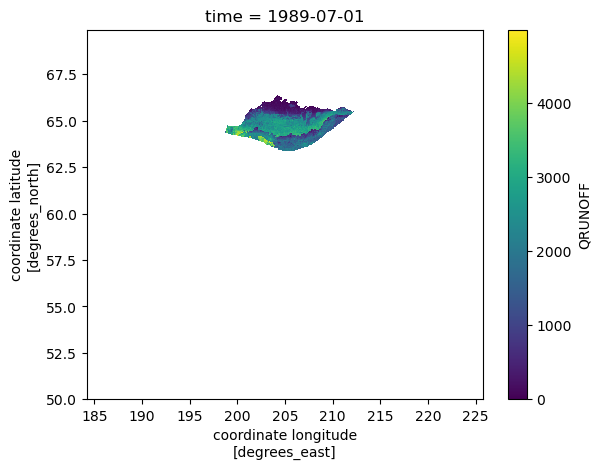

In [22]:
slice = total_qrunoff_P.where(model_grid.OBJECTID.values == 4).sel(time="1989-07-01T00:00:00.000000000")
slice.plot()

In [23]:
### Data visualization: Cartesian grid (but for wintertime)

## REGIONAL

region_dic = {1:"West Coast",
              2:"Aleutians",
              3:"Central Interior",
              4:"Northern Slope",
              5:"NE Interior",
              6:"SE Interior",
              7:"Cook Inlet",
              8:"NW Gulf",
              9:"Bristol Bay",
              10:"North Panhandle",
              11:"NE Gulf",
              12:"Central Panhandle",
              13:"South Panhandle"}

# important helper function to get a winter season
def winterizer(ds):
    """Takes a dataset in, returns a version with means for the winter months."""
    djfm = ds.sel(time=ds.time.dt.month.isin([12, 1, 2, 3]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    
    djfm.coords['season_year'] = get_season_year(djfm.time).astype('int32')

    return djfm.groupby('season_year').mean(dim=('lat','lon', 'time'))

# important helper function for getting the data we want
def localizer(ds_list, var):
    storage = [x.where(model_grid.OBJECTID.values == var) for x in ds_list]
    return storage

## MAKING THE OVERALL FIGURE
plt.suptitle(f"Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations (DJFM) by Region")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 30), dpi=600, constrained_layout=True)
fig.patch.set_facecolor('#ffffff')
axes = axes.flatten()
fig.delaxes(axes[-1])

for i, ax in enumerate(axes):
    magic = i + 1
    i = i + 1

    local_qrunoff_P, local_qrunoff_H, local_qrunoff_M = localizer([total_qrunoff_P, total_qrunoff_H, total_qrunoff_M], magic)
    local_temp_P, local_temp_H, local_temp_M = localizer([total_temp_P, total_temp_H, total_temp_M], magic)
    local_precip_P, local_precip_H, local_precip_M = localizer([total_precip_P, total_precip_H, total_precip_M], magic)

    # years value we'll use later
    years_P = [x.item() for x in winterizer(local_qrunoff_P).season_year.values]
    years_H = [x.item() for x in winterizer(local_qrunoff_H).season_year.values]
    years_M = [x.item() for x in winterizer(local_qrunoff_M).season_year.values]

    # this value is the center of our coordinate grid.
    # we define all points relative to these values.
    #print(f"x: {winterizer(local_precip_P).mean()}, y: {winterizer(local_temp_P).mean()}")
    
    # they're floated because otherwise the tick marker will go crazy later
    x_origin, y_origin = float(winterizer(local_precip_P).values.mean()), float(winterizer(local_temp_P).values.mean())

    ## HISTORICAL
    # color
    precip_ratio_values_P = [(winterizer(local_qrunoff_P).sel(season_year=x).values / winterizer(local_precip_P).sel(season_year=x).values).item() for x in years_P]
    # y axis 
    temp_values_P = [(winterizer(local_temp_P).sel(season_year=x).values).item() - y_origin for x in years_P]
    # x axis
    precip_values_P = [(winterizer(local_precip_P).sel(season_year=x).values).item() - x_origin for x in years_P]

    ## FUTURE HOT
    # color
    precip_ratio_values_H = [(winterizer(local_qrunoff_H).sel(season_year=x).values / winterizer(local_precip_H).sel(season_year=x).values).item() for x in years_H]
    # y axis 
    temp_values_H = [(winterizer(local_temp_H).sel(season_year=x).values).item() - y_origin for x in years_H]
    # x axis
    precip_values_H = [(winterizer(local_precip_H).sel(season_year=x).values).item() - x_origin for x in years_H]

    ## FUTURE MODERATE
    # color
    precip_ratio_values_M = [(winterizer(local_qrunoff_M).sel(season_year=x).values / winterizer(local_precip_M).sel(season_year=x).values).item() for x in years_M]
    # y axis 
    temp_values_M = [(winterizer(local_temp_M).sel(season_year=x).values).item() - y_origin for x in years_M]
    # x axis
    precip_values_M = [(winterizer(local_precip_M).sel(season_year=x).values).item() - x_origin for x in years_M]

    all_heats = np.concatenate([
        precip_ratio_values_P,
        precip_ratio_values_H,
        precip_ratio_values_M
    ])

    vmin, vmax = all_heats.min(), all_heats.max()
    # We're defining it manually because using calculated values is extremely error-prone
    xmin, xmax = -90, 160
    #xmin, xmax = -150, 150
    ymin, ymax = -2.5, 7
    #ymin, ymax = -14, 14
    ticks_x = 10
    #ticks_x = 20
    ticks_y = 2
    #ticks_y = 4

    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-0.05*(ymax-ymin), ymax+0.05*(ymax-ymin)), aspect='auto')

    # axes styling
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #ax.set_xlabel('Precipitation $(mm/yr)$',rotation=-270)
    #ax.set_ylabel('Temperature $(Kelvins)$',rotation=0)

    # grid ticks
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
    
    ax.xaxis.set_major_locator(MultipleLocator(ticks_x * 5))
    ax.xaxis.set_minor_locator(MultipleLocator(ticks_x / 2))
    ax.yaxis.set_major_locator(MultipleLocator(ticks_y))
    ax.yaxis.set_minor_locator(MultipleLocator(ticks_y / 2))

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{(y + y_origin):.2f}'))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{(x + x_origin):.2f}'))
    
    if i <= 13: # annoyingly, we have one more plot than axis, this patches that
        ax.set_title(f"{region_dic[i]}")
        print(f"y test: {(1 + y_origin):.2f}, x test: {(1 + x_origin):.2f}, run: {region_dic[i]}")
        print(f"type of x_origin: {type(x_origin)}, type of y_origin: {type(y_origin)}")
        print(f"finished math for: {region_dic[i]}")
    else:
        pass

    # the easiest way to make plots
    sc1 = ax.scatter(precip_values_P, temp_values_P, c=precip_ratio_values_P, label="Past",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="o")
    sc2 = ax.scatter(precip_values_H, temp_values_H, c=precip_ratio_values_H, label="Future (Hot)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="s")
    sc3 = ax.scatter(precip_values_M, temp_values_M, c=precip_ratio_values_M, label="Future (Moderate)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="d")
    print(f"finished plot number: {i}")

plt.show()
#fig.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
#fig.legend()


y test: 261.16, x test: 560.15, run: West Coast
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finished math for: West Coast
finished plot number: 1
y test: 272.69, x test: 1986.19, run: Aleutians
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finished math for: Aleutians
finished plot number: 2
y test: 258.68, x test: 446.27, run: Central Interior
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finished math for: Central Interior
finished plot number: 3
y test: 253.72, x test: 273.67, run: Northern Slope
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finished math for: Northern Slope
finished plot number: 4
y test: 254.41, x test: 245.44, run: NE Interior
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finished math for: NE Interior
finished plot number: 5
y test: 260.65, x test: 566.93, run: SE Interior
type of x_origin: <class 'float'>, type of y_origin: <class 'float'>
finish

<Figure size 640x480 with 0 Axes>

In [24]:
### Data visualization: Cartesian grid (but for wintertime)

## REGIONAL

region_dic = {1:"West Coast",
              2:"Aleutians",
              3:"Central Interior",
              4:"Northern Slope",
              5:"NE Interior",
              6:"SE Interior",
              7:"Cook Inlet",
              8:"NW Gulf",
              9:"Bristol Bay",
              10:"North Panhandle",
              11:"NE Gulf",
              12:"Central Panhandle",
              13:"South Panhandle"}

# important helper function to get a winter season
def winterizer(ds):
    """Takes a dataset in, returns a version with means for the winter months."""
    djfm = ds.sel(time=ds.time.dt.month.isin([12, 1, 2, 3]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(
            year.where(month != 12, year + 1),
            dims='time'
        )
    
    djfm.coords['season_year'] = get_season_year(djfm.time).astype('int32')

    return djfm.groupby('season_year').mean(dim=('lat','lon', 'time'))

# important helper function for getting the data we want
def localizer(ds_list, var):
    storage = [x.where(model_grid.OBJECTID.values == var) for x in ds_list]
    return storage

## MAKING THE OVERALL FIGURE
plt.suptitle(f"Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations (DJFM) by Region")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 30), dpi=600, constrained_layout=True)
fig.patch.set_facecolor('#ffffff')
axes = axes.flatten()
fig.delaxes(axes[-1])

storage = dict()

for i, ax in enumerate(axes):
    magic = i + 1
    i = i + 1

    local_qrunoff_P, local_qrunoff_H, local_qrunoff_M = localizer([total_qrunoff_P, total_qrunoff_H, total_qrunoff_M], magic)
    local_temp_P, local_temp_H, local_temp_M = localizer([total_temp_P, total_temp_H, total_temp_M], magic)
    local_precip_P, local_precip_H, local_precip_M = localizer([total_precip_P, total_precip_H, total_precip_M], magic)

    # years value we'll use later
    years_P = [x.item() for x in winterizer(local_qrunoff_P).season_year.values]
    years_H = [x.item() for x in winterizer(local_qrunoff_H).season_year.values]
    years_M = [x.item() for x in winterizer(local_qrunoff_M).season_year.values]

    # this value is the center of our coordinate grid.
    # we define all points relative to these values.
    print(f"x: {winterizer(local_precip_P).values.mean()}, y: {winterizer(local_temp_P).values.mean()}, run: {region_dic[i]}")
    x_origin, y_origin = winterizer(local_precip_P), winterizer(local_temp_P)
    storage[region_dic[i]] = (x_origin, y_origin)

#fig.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
#fig.legend()


x: 559.1492919921875, y: 260.15594482421875, run: West Coast
x: 1985.1934814453125, y: 271.692626953125, run: Aleutians
x: 445.2709045410156, y: 257.68450927734375, run: Central Interior
x: 272.6715087890625, y: 252.71620178222656, run: Northern Slope
x: 244.44056701660156, y: 253.4147491455078, run: NE Interior
x: 565.92822265625, y: 259.64788818359375, run: SE Interior
x: 1507.890625, y: 264.79547119140625, run: Cook Inlet
x: 3005.44189453125, y: 269.15203857421875, run: NW Gulf
x: 1108.394775390625, y: 265.2657470703125, run: Bristol Bay
x: 3071.59716796875, y: 266.9920349121094, run: North Panhandle
x: 4039.04345703125, y: 268.22125244140625, run: NE Gulf
x: 3777.642822265625, y: 269.9556579589844, run: Central Panhandle
x: 2886.0146484375, y: 272.48699951171875, run: South Panhandle


KeyError: 14

<Figure size 640x480 with 0 Axes>

In [ ]:
storage.keys()

In [ ]:
storage['West Coast'][1].values.mean()

In [ ]:
total_precip_P